# ORB walkthrough

Source: https://docs.opencv.org/4.5.2/d1/d89/tutorial_py_orb.html

Code source: https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/orb.py

## Description

> ORB is a fusion of the FAST key point detector and BRIEF
> descriptor with some modifications. Initially to determine
> the key points, it uses FAST. Then a Harris corner measure is
> applied to find top N points. FAST does not compute the
> orientation and is rotation variant. It computes the intensity
> weighted centroid of the patch with located corner at center.
> The direction of the vector from this corner point to centroid
> gives the orientation. Moments are computed to improve the
> rotation invariance. The descriptor BRIEF poorly performs if
> there is an in-plane rotation. In ORB, a rotation matrix is
> computed using the orientation of patch and then the BRIEF
> descriptors are steered according to the orientation.
> -- <cite>[Ebrahim Karami, Siva Prasad, and Mohamed Shehata][1]</cite>

 

[1]: https://arxiv.org/ftp/arxiv/papers/1710/1710.02726.pdf


In [1]:
# imports
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import preprocessing as pre
import cv as cvfunctions

import math

import skimage as ski
from skimage.feature import ORB, match_descriptors, corner_fast, corner_orientations
from skimage.morphology import octagon


(1953, 2216, 3)


Text(0.5, 1.0, 'Bottom part')

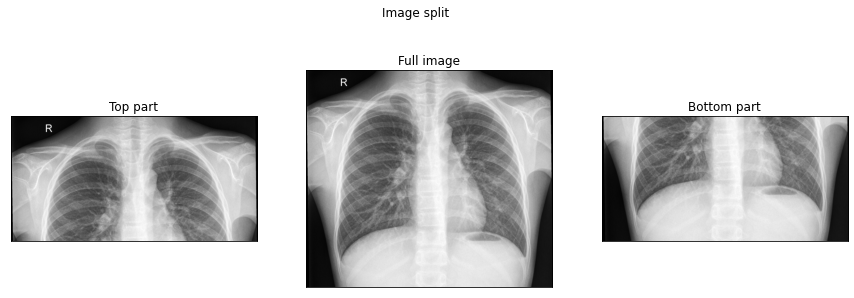

In [2]:
## Image preprocessing 

# choose 1 image: NORMAL2-IM-0329-0001.jpeg
filename = 'NORMAL2-IM-0329-0001.jpeg'
im = cv2.imread('images/x-ray/'+filename)

# divide image into two parts with 30% overlap
full,top,bottom = pre.splitY(0.3,im)

# convert to gray scale
topGray = cv2.cvtColor(top, cv2.COLOR_BGR2GRAY)
bottomGray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs = axs.flatten()
for img, ax in zip([top,full,bottom], axs):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(img)
fig.suptitle('Image split')
axs[0].set_title('Top part')
axs[1].set_title('Full image')
axs[2].set_title('Bottom part')
fig.show()

First it use FAST to find keypoints
by comparing the brightness of pixel $p$ to the surrounding 16 pixels that are in a small circle around $p$. Pixels in the circle is then sorted into three classes (lighter than $p$, darker than $p$ or similar to $p$).

![pixels considered](images/notebooks/orb_ring.jpg "FAST chosen pixels")

If more than 8 pixels are darker or brighter than $p$ than it is selected as a keypoint.




In [ ]:
def FAST_keypoints(image):
    num_rows, num_cols = image.shape[:2]
    def isKeypoint(coord):
        (row, col) = coord
        similarity_threshold = np.max(image) * 0.15 # determines number of matches
        # to close to border
        if row < 3 or row > (num_rows - 4) or col < 3 or col > (num_cols - 4):
            return False
        delta = np.array([(-3, 0), (-3, 1), (-2, 2), (-1, 3), 
                        (0, 3),  (1, 3),  (2, 2),  (3, 1),
                        (3, 0),  (3,-1),  (2,-2),  (1,-3),
                        (0,-3), (-1,-3), (-2,-2), (-3,-1)])
        brighter = []
        same = []
        darker = []
        center = image[row,col]
        for dc in delta:
            d_row = dc[0]
            d_col = dc[1]
            neighbor = image[row+d_row,col+d_col]
            difference = float(neighbor) - float(center)
            if difference >= similarity_threshold:
                brighter.append(dc)
            elif -difference >= similarity_threshold:
                darker.append(dc)
            else:
                same.append(dc)
        #print(len(brighter))
        #print(len(same))
        #print(len(darker))
        return len(brighter) + len(darker) >= 8
    keypoints = []
    for r in range(0, num_rows-1):
      for c in range(0, num_cols-1):
        if isKeypoint((r,c)):
          keypoints.append(cv2.KeyPoint(c, r, 1))
    return keypoints

In [ ]:
img = bottomGray
  
scale_percent = 20 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
kp = FAST_keypoints(resized)

Apply Harris corner measure to find top N points among them.

In [ ]:
def best1000_using_harris_measure(image, kpts, s=15, eps=1.3, k=0.01):
    harrisVal = cvfunctions.harrisMeasure(image, s, eps, k)
    def sortByHarrisMeasure(keypoint):
        (c,r) = keypoint.pt
        c = int(c)
        r = int(r)
        return harrisVal[r,c]
    kpts.sort(reverse=True,key=sortByHarrisMeasure)
    return kpts[:1000]
best = best1000_using_harris_measure(resized, kp)
kp_img = cv2.drawKeypoints(resized, best, None, (255,0,0), flags=0)
plt.imshow(kp_img)

It also use pyramid to produce multiscale-features.

BUT that is skipped in this walkthrough...

In [ ]:
#Using Skimage to do the same (but without openCV types)
skimage_orb = ORB(n_keypoints=1000, fast_n=8, n_scales=1)
skimage_orb.detect(img)
keypoints = skimage_orb.keypoints
print(keypoints)

One problem is that, FAST doesn't compute the orientation. To determine an orientation, ORB uses the intensity centroid (center of mass, which is assumed to be offset from the center), and then determinses the orientation giving the vector from the center to the intensity centroid.

The centroid has a center $C = (\frac{m_{10}}{00}, \frac{m_{01}}{00})$

$$
m_{pq} = \sum_{x,y} x^p \cdot y^q \cdot I(x,y)
$$

A vector from the keypoint center O to C 
vector has the angle $\Theta = \text{atan2}(m_{01},m_{10})$, this angle is then used as orientation.




In [ ]:
def corner_orientations(image, corners, mask=octagon(3,2)):
    """Compute the orientation of corners.
    The orientation of corners is computed using the first order central moment
    i.e. the center of mass approach. The corner orientation is the angle of
    the vector from the corner coordinate to the intensity centroid in the
    local neighborhood around the corner calculated using first order central
    moment.
    Parameters
    ----------
    image : 2D array
        Input grayscale image.
    corners : (N, 2) array
        Corner coordinates as ``(row, col)``.
    mask : 2D array
        Mask defining the local neighborhood of the corner used for the
        calculation of the central moment.
    """
    cmask = np.ascontiguousarray(mask != 0, dtype=np.uint8)

    mrows = mask.shape[0]
    mcols = mask.shape[1]
    mrows2 = (mrows - 1) // 2
    mcols2 = (mcols - 1) // 2
    cimage = np.pad(image, (mrows2, mcols2),
                            mode='constant',
                            constant_values=0)
    orientations = np.zeros(corners.shape[0], dtype=np.float64)
    for i in range(corners.shape[0]):
        r0 = int(corners[i, 0])
        c0 = int(corners[i, 1])

        m01 = 0
        m10 = 0

        for r in range(mrows):
            m01_tmp = 0
            for c in range(mcols):
                if cmask[r, c]:
                    curr_pixel = cimage[r0 + r, c0 + c]
                    m10 += curr_pixel * (c - mcols2)
                    m01_tmp += curr_pixel
            m01 += m01_tmp * (r - mrows2)

        orientations[i] = math.atan2(m01, m10)
    return orientations


Now for descriptors, ORB use BRIEF descriptors. But we have already seen that BRIEF performs poorly with rotation. So what ORB does is to "steer" BRIEF according to the orientation of keypoints. For any feature set of $n$ binary tests at location $(x_i,y_i)$, define a $2 \times n$ matrix, $S$ which contains the coordinates of these pixels. Then using the orientation of patch, $\Theta$, its rotation matrix is found and rotates the $S$ to get steered(rotated) version $S_\Theta$.



In [ ]:
orientations = corner_orientations(img, keypoints)
print(np.rad2deg(orientations))

ORB discretize the angle to increments of $\frac{2\pi}{30}$ (12 degrees), and construct a lookup table of precomputed BRIEF patterns. As long as the keypoint orientation $\Theta$ is consistent across views, the correct set of points $S_\Theta$ will be used to compute its descriptor.

In [ ]:
# using skimage instead

detector_extractor1 = ORB(n_keypoints=2000, fast_n=8, n_scales=1)
detector_extractor2 = ORB(n_keypoints=2000, fast_n=8, n_scales=1)
detector_extractor1.detect_and_extract(bottomGray)
detector_extractor2.detect_and_extract(topGray)

matches = match_descriptors(detector_extractor1.descriptors,
                            detector_extractor2.descriptors)

In [ ]:
detector_extractor1.detect()

In [ ]:
kp1 = [cv2.KeyPoint(x[1], x[0], 1) for x in detector_extractor1.keypoints]
kp2 = [cv2.KeyPoint(x[1], x[0], 1) for x in detector_extractor2.keypoints]
# draw key point on image
result_im1 = cv2.drawKeypoints(topGray, kp1, None, (255,0,0), flags=0)
result_im2 = cv2.drawKeypoints(bottomGray, kp2, None,(255,0,0), flags=0)

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs = axs.flatten()
for img, ax in zip([result_im1,result_im2], axs):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(img)
fig.suptitle('ORB keypoints')
axs[0].set_title('Top')
axs[1].set_title('Bottom part')
plt.show()
